# Práctica 4: Clasificación Semi-Supervisada

**Objetivo**: El objetivo de esta práctica es introducir los conceptos de clasificación semi-supervisada.

La práctica consiste en dos tareas:

## TAREA 1: Implementación de un método
- Seleccione un algoritmo de los indicados en la teoría que implemente aprendizaje semi-supervisado de cualquiera de los paradigmas estudiados.
- Implemente el algoritmo.
- Seleccione al menos un dataset semi-supervisado y evalúe el algoritmo implementado.

## TAREA 2: Comparación de métodos
1. Seleccione al menos dos algoritmos de los disponibles en las bibliotecas indicadas.
2. Seleccione al menos tres problemas semi-supervisados de los repositorios indicados.
3. Aplique los algoritmos seleccionados a los datasets.
4. Compare los resultados y explique las conclusiones obtenidas.

En este notebook se incluye un ejemplo con dos tareas:
1. **Tarea 1**: Implementación y uso de un método de Self-Training.
2. **Tarea 2**: Comparación de Label Spreading y Self-Training sobre datasets generados sintéticamente.


## TAREA 1: Implementación de un método de Self-Training

En esta celda se muestra la implementación de un algoritmo de *Self-Training* desde cero y su posterior evaluación en un dataset sintético. Se entrena un modelo con un pequeño subconjunto etiquetado y se itera sobre instancias no etiquetadas, pseudo-etiquetándolas de forma progresiva si el modelo está suficientemente seguro (superando un determinado umbral de confianza).

In [5]:
import numpy as np
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

def self_training(X_labeled, y_labeled, X_unlabeled, base_classifier,
                  confidence_threshold=0.9, max_iter=10):
    """
    Self-Training method.

    Parameters
    ----------
    X_labeled : array-like, shape (n_labeled_samples, n_features)
        Labeled dataset.
    y_labeled : array-like, shape (n_labeled_samples,)
        Corresponding labels for X_labeled.
    X_unlabeled : array-like, shape (n_unlabeled_samples, n_features)
        Unlabeled dataset.
    base_classifier : scikit-learn estimator
        Base classifier that must support at least the `predict_proba` method.
        (If it does not support `predict_proba`, confidence is assumed to be 1 for all instances).
    confidence_threshold : float, optional (default=0.9)
        Minimum probability threshold to accept pseudo-labeled instances.
    max_iter : int, optional (default=10)
        Maximum number of self-training iterations.

    Returns
    -------
    trained_classifier : scikit-learn estimator
        The trained classifier at the end of the process (or after exhausting
        the unlabeled instances that meet the confidence threshold).
    """

    # Copies to avoid modifying the original data
    X_l = X_labeled.copy()
    y_l = y_labeled.copy()
    X_u = X_unlabeled.copy()

    for i in range(1, max_iter + 1):
        # Create/Clone the classifier to train it from scratch in each iteration
        current_clf = clone(base_classifier)
        current_clf.fit(X_l, y_l)

        # If the classifier has predict_proba, use it to calculate confidence
        if hasattr(current_clf, "predict_proba"):
            probs = current_clf.predict_proba(X_u)
            pred_labels = np.argmax(probs, axis=1)
            max_probs = np.max(probs, axis=1)
        else:
            # If it does not have predict_proba, use predict and assume confidence=1
            pred_labels = current_clf.predict(X_u)
            max_probs = np.ones(len(X_u))

        # Select instances with confidence >= confidence_threshold
        high_conf_idx = np.where(max_probs >= confidence_threshold)[0]

        if len(high_conf_idx) == 0:
            print(f"Iteration {i}: No instances found with confidence >= {confidence_threshold}. Ending.")
            break

        # Add to the labeled dataset
        X_l = np.vstack([X_l, X_u[high_conf_idx]])
        y_l = np.hstack([y_l, pred_labels[high_conf_idx]])

        # Remove from the unlabeled dataset
        X_u = np.delete(X_u, high_conf_idx, axis=0)

        print(f"Iteration {i}: Added {len(high_conf_idx)} high-confidence instances.")

        # If no more unlabeled examples remain, end
        if len(X_u) == 0:
            print(f"Iteration {i}: No more unlabeled instances remaining. Ending.")
            break

    # Train a final classifier with all accumulated labeled data
    final_clf = clone(base_classifier)
    final_clf.fit(X_l, y_l)

    return final_clf

# Example usage with synthetic data
if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    # Generate synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=10,
                               n_informative=3, n_classes=2,
                               random_state=42)

    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42)

    # Take only 20% of y_train as labeled
    labeled_percentage = 0.2
    num_labeled = int(len(y_train) * labeled_percentage)
    X_labeled = X_train[:num_labeled]
    y_labeled = y_train[:num_labeled]

    # The rest is considered unlabeled
    X_unlabeled = X_train[num_labeled:]

    # Train using Self-Training with a RandomForest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    self_trained_model = self_training(
        X_labeled,
        y_labeled,
        X_unlabeled,
        rf,
        confidence_threshold=0.9,
        max_iter=10
    )

    # Evaluate on the test set
    y_pred = self_trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy after Self-Training:", accuracy)


Iteration 1: Added 357 high-confidence instances.
Iteration 2: Added 46 high-confidence instances.
Iteration 3: Added 21 high-confidence instances.
Iteration 4: Added 12 high-confidence instances.
Iteration 5: Added 9 high-confidence instances.
Iteration 6: Added 5 high-confidence instances.
Iteration 7: Added 10 high-confidence instances.
Iteration 8: Added 7 high-confidence instances.
Iteration 9: Added 6 high-confidence instances.
Iteration 10: Added 9 high-confidence instances.
Test accuracy after Self-Training: 0.8933333333333333


## TAREA 2: Comparación de Label Spreading y Self-Training

En la siguiente celda se ilustra cómo comparar dos métodos de clasificación semi-supervisada (Label Spreading y Self-Training) en al menos dos datasets sintéticos. En una entrega final, pueden agregarse más datasets o reemplazar estos por otros de repositorios reconocidos, tal como lo solicita la consigna.

Evaluando Iris con Label Spreading:
Resultados en dataset: Iris
Accuracy: 1.0000
F1-score (macro): 1.0000
Matriz de confusión:
 [[8 0 0]
 [0 3 0]
 [0 0 7]] 

Evaluando Iris con Self-Training:
Resultados en dataset: Iris
Accuracy: 1.0000
F1-score (macro): 1.0000
Matriz de confusión:
 [[8 0 0]
 [0 3 0]
 [0 0 7]] 

Evaluando Wine con Label Spreading:
Resultados en dataset: Wine
Accuracy: 0.6818
F1-score (macro): 0.6456
Matriz de confusión:
 [[6 1 1]
 [0 7 4]
 [1 0 2]] 

Evaluando Wine con Self-Training:
Resultados en dataset: Wine
Accuracy: 0.7727
F1-score (macro): 0.5573
Matriz de confusión:
 [[ 6  2  0]
 [ 0 11  0]
 [ 0  3  0]] 

Evaluando Breast Cancer con Label Spreading:


/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Resultados en dataset: Breast Cancer
Accuracy: 0.9130
F1-score (macro): 0.9059
Matriz de confusión:
 [[22  4]
 [ 2 41]] 

Evaluando Breast Cancer con Self-Training:
Resultados en dataset: Breast Cancer
Accuracy: 0.8986
F1-score (macro): 0.8892
Matriz de confusión:
 [[21  5]
 [ 2 41]] 



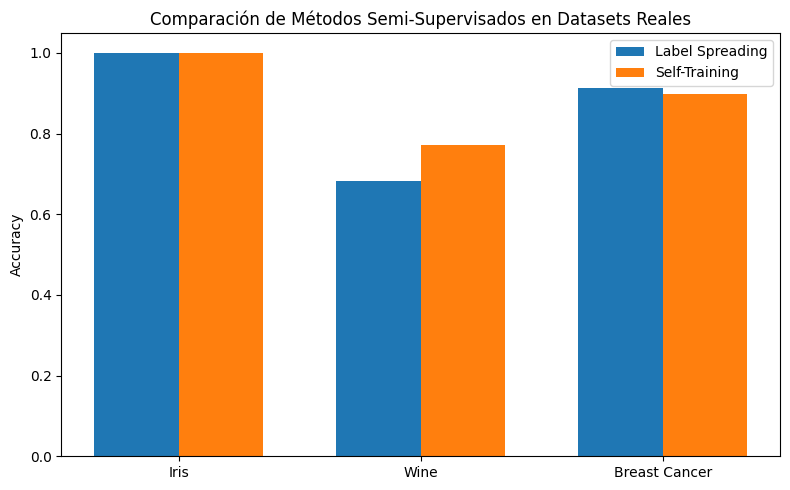

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

def load_real_datasets():
    """
    Carga 3 datasets clásicos de scikit-learn:
      - Iris
      - Wine
      - Breast Cancer

    Retorna un diccionario con {nombre_dataset: (X, y_modificado)}
    donde y_modificado tiene un 60% de las etiquetas marcadas como -1
    (simulando la falta de etiquetas).
    """
    datasets = {}

    # 1) IRIS
    iris = load_iris()
    X_iris = iris.data
    y_iris = iris.target
    # Enmascaramos el 60% de las etiquetas
    y_iris_masked = y_iris.copy()
    rng = np.random.default_rng(42)
    mask_iris = rng.choice(len(y_iris_masked),
                           size=int(0.6 * len(y_iris_masked)),
                           replace=False)
    y_iris_masked[mask_iris] = -1
    datasets["Iris"] = (X_iris, y_iris_masked)

    # 2) WINE
    wine = load_wine()
    X_wine = wine.data
    y_wine = wine.target
    y_wine_masked = y_wine.copy()
    mask_wine = rng.choice(len(y_wine_masked),
                           size=int(0.6 * len(y_wine_masked)),
                           replace=False)
    y_wine_masked[mask_wine] = -1
    datasets["Wine"] = (X_wine, y_wine_masked)

    # 3) BREAST CANCER
    cancer = load_breast_cancer()
    X_cancer = cancer.data
    y_cancer = cancer.target
    y_cancer_masked = y_cancer.copy()
    mask_cancer = rng.choice(len(y_cancer_masked),
                             size=int(0.6 * len(y_cancer_masked)),
                             replace=False)
    y_cancer_masked[mask_cancer] = -1
    datasets["Breast Cancer"] = (X_cancer, y_cancer_masked)

    return datasets

def evaluate_semi_supervised(model, X, y, dataset_name):
    """
    Entrena el modelo semi-supervisado únicamente con las muestras
    que tienen etiqueta (y != -1) y luego evalúa la precisión y f1-score
    en un conjunto de test separado.

    Devuelve (accuracy, f1_score, confusion_matrix).
    """
    # Filtramos datos etiquetados
    labeled_mask = (y != -1)

    X_labeled = X[labeled_mask]
    y_labeled = y[labeled_mask]

    # Dividimos en train/test solo los etiquetados
    X_train, X_test, y_train, y_test = train_test_split(
        X_labeled,
        y_labeled,
        test_size=0.3,
        random_state=42
    )

    # Entrenamos el modelo
    model.fit(X_train, y_train)

    # Predecimos en test
    y_pred = model.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' para multi-clase
    cm = confusion_matrix(y_test, y_pred)

    print(f"Resultados en dataset: {dataset_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Matriz de confusión:\n", cm, "\n")

    return acc, f1, cm


if __name__ == "__main__":

    # 1) Cargamos los datasets reales
    real_datasets = load_real_datasets()

    # 2) Definimos los métodos a comparar
    label_spreading = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.2, max_iter=30)
    self_training = SelfTrainingClassifier(estimator=SVC(probability=True), max_iter=10)

    # 3) Evaluamos en cada dataset
    results = {}
    for dataset_name, (X, y) in real_datasets.items():
        print("========================================")
        print(f"Evaluando {dataset_name} con Label Spreading:")
        acc_ls, f1_ls, cm_ls = evaluate_semi_supervised(label_spreading, X, y, dataset_name)
        results[(dataset_name, 'Label Spreading')] = (acc_ls, f1_ls)

        print(f"Evaluando {dataset_name} con Self-Training:")
        acc_st, f1_st, cm_st = evaluate_semi_supervised(self_training, X, y, dataset_name)
        results[(dataset_name, 'Self-Training')] = (acc_st, f1_st)

    # 4) Gráfica comparativa de Accuracy
    dataset_names = list(real_datasets.keys())
    methods = ['Label Spreading', 'Self-Training']

    accuracies = []
    for ds in dataset_names:
        acc_ls, _ = results[(ds, 'Label Spreading')]
        acc_st, _ = results[(ds, 'Self-Training')]
        accuracies.append([acc_ls, acc_st])
    accuracies = np.array(accuracies)

    import matplotlib.pyplot as plt

    x = np.arange(len(dataset_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, accuracies[:, 0], width, label='Label Spreading')
    ax.bar(x + width/2, accuracies[:, 1], width, label='Self-Training')

    ax.set_ylabel('Accuracy')
    ax.set_title('Comparación de Métodos Semi-Supervisados en Datasets Reales')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_names)
    ax.legend()
    plt.tight_layout()
    plt.show()
